In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import glob
from PIL import ImageFile

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback
import random, datetime, os, shutil, math

## 1. Load the images in appropriate data structures in your program, ready to be passed as input to the model for training. Consider input image size to be 224x224x3. [2 points]

In [30]:
train="Sports_Dataset/archive/train"
test="Sports_Dataset/archive/test"

filepaths_train = list(glob.glob(train+'/**/*.jpg'))
filepaths_test = list(glob.glob(test+'/**/*.jpg'))
df = []
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))
    

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)
    
    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df
    #print(df)

train_df = proc_img(filepaths_train)
#print(train_df)
test_df = proc_img(filepaths_test)

print(f'Number of training pictures: {train_df.shape[0]}')
print(f'Number of test pictures: {test_df.shape[0]}')

print(filepaths_train)

Number of training pictures: 10416
Number of test pictures: 365
['Sports_Dataset/archive/train\\air hockey\\001.jpg', 'Sports_Dataset/archive/train\\air hockey\\002.jpg', 'Sports_Dataset/archive/train\\air hockey\\003.jpg', 'Sports_Dataset/archive/train\\air hockey\\004.jpg', 'Sports_Dataset/archive/train\\air hockey\\005.jpg', 'Sports_Dataset/archive/train\\air hockey\\006.jpg', 'Sports_Dataset/archive/train\\air hockey\\007.jpg', 'Sports_Dataset/archive/train\\air hockey\\008.jpg', 'Sports_Dataset/archive/train\\air hockey\\009.jpg', 'Sports_Dataset/archive/train\\air hockey\\010.jpg', 'Sports_Dataset/archive/train\\air hockey\\011.jpg', 'Sports_Dataset/archive/train\\air hockey\\012.jpg', 'Sports_Dataset/archive/train\\air hockey\\013.jpg', 'Sports_Dataset/archive/train\\air hockey\\014.jpg', 'Sports_Dataset/archive/train\\air hockey\\015.jpg', 'Sports_Dataset/archive/train\\air hockey\\016.jpg', 'Sports_Dataset/archive/train\\air hockey\\017.jpg', 'Sports_Dataset/archive/train\\air

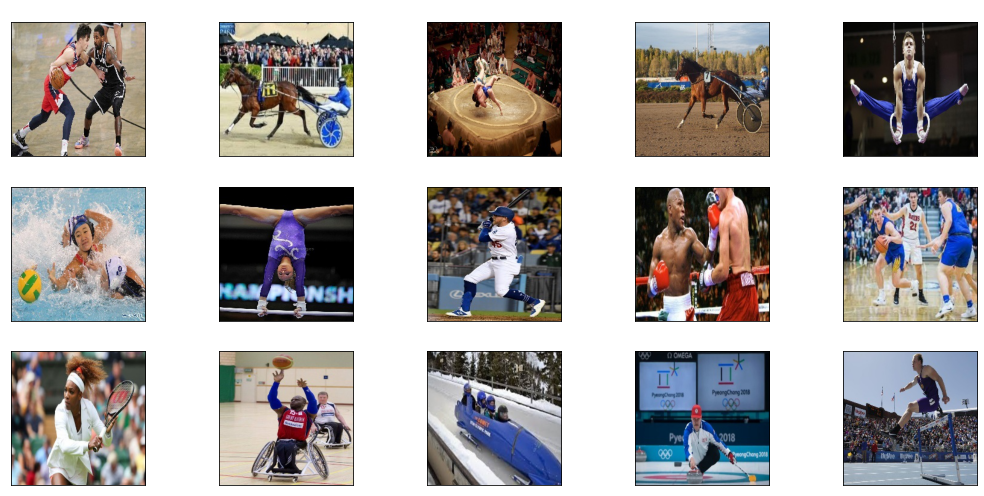

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]))
    ax.set_title(train_df.Label[i]).set_color('white')
plt.tight_layout()
plt.show()

In [6]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 8333 validated image filenames belonging to 73 classes.
Found 365 validated image filenames belonging to 73 classes.


## 2. Configure the CNN model (use keras tensorflow), an indicative (minimal) configuration is as below. Take activation function (A)=relu. Feel free to use standard values for anything that is not mentioned (eg, take pool size 2x2, filter size 3x3, and so on). [3 points]
conv --> A --> pool
(conv --> A) --> (conv --> A) --> pool
full connected layer --> A
softmax classifier


In [7]:
image_size = (224,224,3)
num_classes = 73

In [8]:
def cnn(image_size, num_classes):
    classifier = Sequential()
    classifier.add(Conv2D(4, (3, 3), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(8, (2, 2), activation='relu', padding='same'))
    classifier.add(Conv2D(8, (2, 2), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return classifier
    
neuralnetwork_cnn = cnn(image_size, num_classes)
neuralnetwork_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 4)       112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 4)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 8)       136       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 8)       264       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 73)                1

In [9]:
neuralnetwork_cnn = cnn(image_size, num_classes)
neuralnetwork_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 4)       112       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 4)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 8)       136       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 8)       264       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 73)               

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import plot_model

es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=7)
filepath = "sports_classifier.h5"
ckpt = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
rlp = ReduceLROnPlateau(monitor='acc', patience=3, verbose=1)

## 3. Train the CNN model for E epoch (take E=50), save the train_loss, train_acc, validation_loss, validation_acc for each epoch and plot it after training has finished. [3 points]

In [11]:
history = neuralnetwork_cnn.fit_generator(
    generator=train_images, validation_data=test_images,
    callbacks=[es, ckpt, rlp], epochs = 50, 
)

C:\Users\pjatthi\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
261/261 [==============================] - 87s 333ms/step - loss: 3.4451 - acc: 0.1676 - val_loss: 2.5379 - val_acc: 0.3479

Epoch 00001: acc improved from -inf to 0.16765, saving model to sports_classifier.h5
Epoch 2/50
261/261 [==============================] - 96s 368ms/step - loss: 1.3852 - acc: 0.6511 - val_loss: 2.4228 - val_acc: 0.3726

Epoch 00002: acc improved from 0.16765 to 0.65115, saving model to sports_classifier.h5
Epoch 3/50
261/261 [==============================] - 98s 373ms/step - loss: 0.1977 - acc: 0.9600 - val_loss: 3.1539 - val_acc: 0.3644

Epoch 00003: acc improved from 0.65115 to 0.96004, saving model to sports_classifier.h5
Epoch 4/50
261/261 [==============================] - 99s 380ms/step - loss: 0.0368 - acc: 0.9950 - val_loss: 3.2266 - val_acc: 0.3671

Epoch 00004: acc improved from 0.96004 to 0.99496, saving model to sports_classifier.h5
Epoch 5/50
261/261 [==============================] - 97s 370ms/step - loss: 0.0113 - acc: 0.9984 - val_los

<AxesSubplot:>

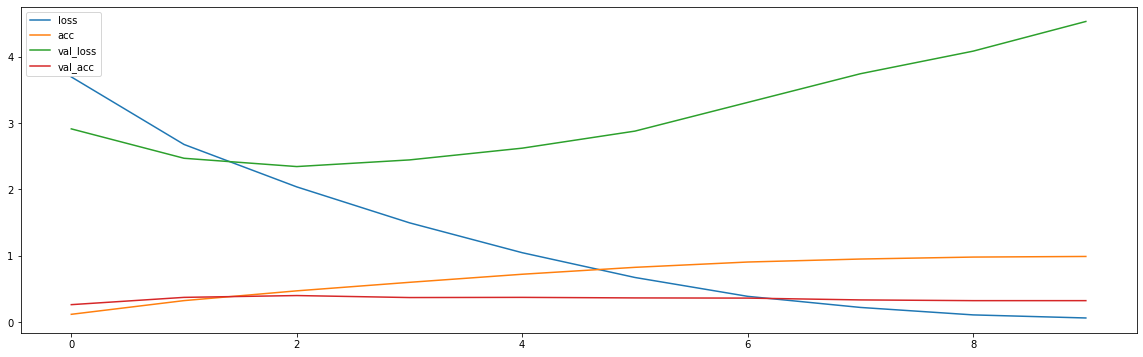

In [10]:
fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).iloc[:, :-1].plot(ax=ax)

## 4. Evaluate the trained CNN model on test data. Print classification results. [1 point]

In [11]:
results = neuralnetwork_cnn.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 4.52812
Test Accuracy: 32.60%


## 5. Can you try to make changes in anyway in the CNN model and improve your test accuracy? Let's call the model constructed as per step-2 above as 'default' and the improvement as 'improved' model. Plot precision and recall for default and improved model in a single bar plot. [3 points]

### To improve accuracy we can try changing number of different hyper parameters like activation function, learning rate, epoch size, neurons, number of hidden layers, filter size, pool size or use pre trained model to predict

In [38]:
def cnn_improved(image_size, num_classes):
    classifier = Sequential()
    classifier.add(Conv2D(4, (3, 3), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(8, (2, 2), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(8, (2, 2), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(8, (2, 2), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(8, (2, 2), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    return classifier
    
neuralnetwork_cnn = cnn(image_size, num_classes)
neuralnetwork_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 4)       112       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 4)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 112, 112, 8)       136       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 112, 112, 8)       264       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 73)               

In [39]:
history = neuralnetwork_cnn.fit_generator(
    generator=train_images, validation_data=test_images,
    callbacks=[es, ckpt, rlp], epochs = 100, 
)

C:\Users\pjatthi\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
261/261 [==============================] - 84s 321ms/step - loss: 3.3959 - acc: 0.1783 - val_loss: 2.6140 - val_acc: 0.3397

Epoch 00001: acc did not improve from 0.99976
Epoch 2/100
261/261 [==============================] - 89s 341ms/step - loss: 1.1113 - acc: 0.7265 - val_loss: 2.7442 - val_acc: 0.3178

Epoch 00002: acc did not improve from 0.99976
Epoch 3/100
261/261 [==============================] - 106s 407ms/step - loss: 0.1061 - acc: 0.9824 - val_loss: 3.5040 - val_acc: 0.3151

Epoch 00003: acc did not improve from 0.99976
Epoch 4/100
261/261 [==============================] - 99s 379ms/step - loss: 0.0182 - acc: 0.9987 - val_loss: 3.4244 - val_acc: 0.3562

Epoch 00004: acc did not improve from 0.99976
Epoch 5/100
261/261 [==============================] - 99s 379ms/step - loss: 0.0072 - acc: 0.9996 - val_loss: 3.5187 - val_acc: 0.3589

Epoch 00005: acc did not improve from 0.99976
Epoch 6/100
261/261 [==============================] - 98s 375ms/step - loss: 0.0103

<AxesSubplot:>

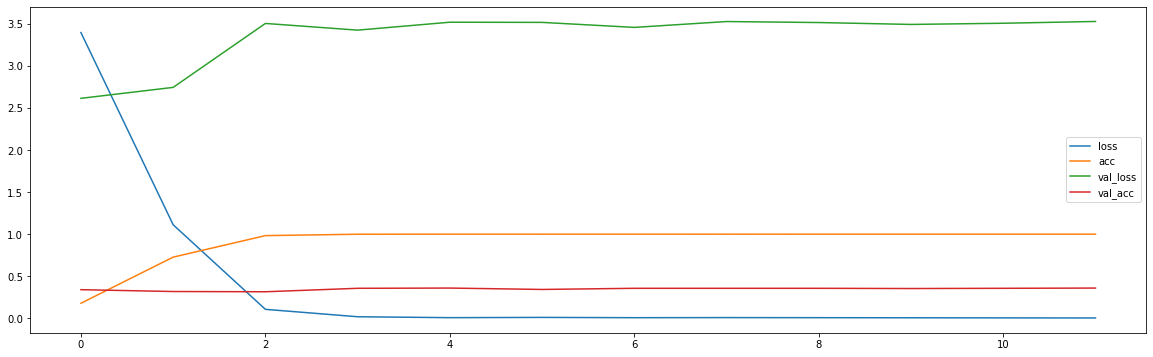

In [40]:
fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).iloc[:, :-1].plot(ax=ax)

In [46]:
results = neuralnetwork_cnn.evaluate(test_images, verbose=0)
new_test = neuralnetwork_cnn.predict(test_images)
new_test_classes = neuralnetwork_cnn.predict_classes(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))
print(results)

C:\Users\pjatthi\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


    Test Loss: 3.52755
Test Accuracy: 35.89%
[3.527550458908081, 0.3589041233062744]


## Try using pretrained model imagenet. 
### Taking too long, could not improve accuracy.

In [48]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
conv_base.summary()

#img_path = 'Sports_Dataset/archive/train/air hockey/001.jpg'
#img = image.load_img(img_path, target_size=(224, 224))
#img_data = image.img_to_array(img)
#img_data = np.expand_dims(img_data, axis=0)
#img_data = preprocess_input(img_data)

#vgg16_feature = model.predict(img_data)

#print(vgg16_feature.shape)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [49]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(num_classes, activation = 'relu'))
model.add(layers.Dense(1, activation = 'softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 73)                1831497   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 74        
Total params: 16,546,259
Trainable params: 16,546,259
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
conv_base.trainable = False

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_generator = train_datagen.flow_from_directory('Sports_Dataset/archive/train',
                                                   target_size= (224,224),
                                                   batch_size= 20,
                                                   class_mode='binary')


Found 10416 images belonging to 73 classes.


In [18]:
validation_generator = test_datagen.flow_from_directory('Sports_Dataset/archive/test',
                                                   target_size= (224,224),
                                                   batch_size= 20,
                                                   class_mode='binary')


Found 365 images belonging to 73 classes.


In [20]:
#from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.optimizers import RMSprop
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
#opt = tf.compat.v1.train.RMSPropOptimizer(learning_rate= 0.001)
#opt = tf.keras.optimizers.RMSprop(lr=0.0001,rho=0.9)

model.compile(loss='binary_crossentropy',optimizer = opt,metrics=['acc'])

In [22]:
history= model.fit(train_generator,
                            steps_per_epoch=100,
                            epochs=30,
                            validation_data=validation_generator,
                            validation_steps=50)

Epoch 1/30
100/100 [==============================] - 586s 6s/step - loss: -293760.5625 - acc: 0.0115 - val_loss: -510997.4688 - val_acc: 0.0136
Epoch 2/30
100/100 [==============================] - 587s 6s/step - loss: -773041.8125 - acc: 0.0090 - val_loss: -1139028.6250 - val_acc: 0.0147
Epoch 3/30
100/100 [==============================] - 756s 8s/step - loss: -1494131.0000 - acc: 0.0110 - val_loss: -2004440.0000 - val_acc: 0.0113
Epoch 4/30
100/100 [==============================] - 588s 6s/step - loss: -2435302.5000 - acc: 0.0130 - val_loss: -3100625.2500 - val_acc: 0.0136
Epoch 5/30
100/100 [==============================] - 577s 6s/step - loss: -3703171.5000 - acc: 0.0140 - val_loss: -4535397.0000 - val_acc: 0.0147
Epoch 6/30
100/100 [==============================] - 576s 6s/step - loss: -5074432.0000 - acc: 0.0090 - val_loss: -6068836.0000 - val_acc: 0.0134
Epoch 7/30
100/100 [==============================] - 581s 6s/step - loss: -6667577.0000 - acc: 0.0100 - val_loss: -78516

<AxesSubplot:>

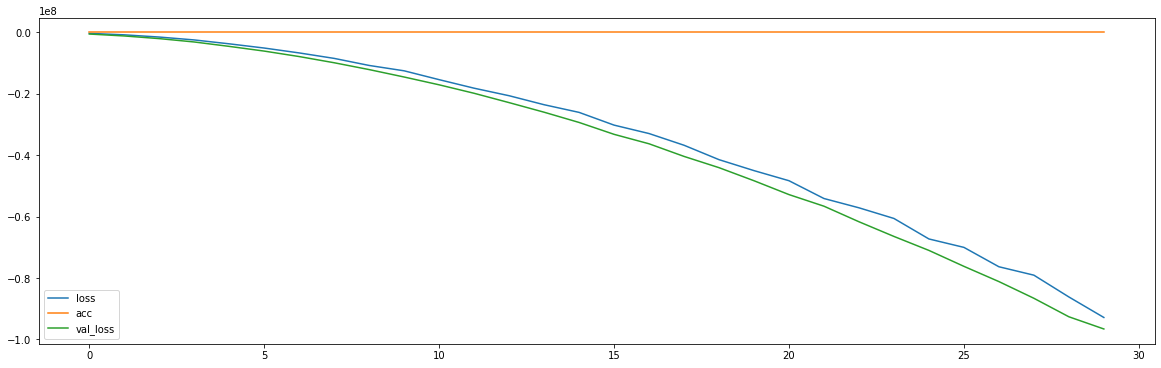

In [23]:
fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).iloc[:, :-1].plot(ax=ax)